# Assignment 4 — KDD Case Study (Wine Quality Regression)

Dataset: [`codesignal/wine-quality`](https://huggingface.co/datasets/codesignal/wine-quality) — red split (1,599 rows, 11 numeric features, target: quality 0–10).

Goal: Predict wine `quality` using KDD stages: Selection → Preprocessing → Transformation → Data Mining → Evaluation/Interpretation.

Environment: Python 3.11 (`.venv`), scikit-learn, pandas, seaborn, SHAP.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

from datasets import load_dataset
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.decomposition import PCA

import shap

sns.set_theme(style="whitegrid")
FIG_DIR = Path("figures")
FIG_DIR.mkdir(exist_ok=True)
RNG = 42
pd.set_option("display.max_columns", 30)

## Selection
- Load red wine split; target = `quality` (ordinal/treated as regression).
- Rationale: small, clean numeric dataset suitable for transformation (scaling/PCA) and regression models.

In [2]:
ds = load_dataset("codesignal/wine-quality", split="red")
df = ds.to_pandas()
df.shape, df.head()

((1599, 12),
    fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
 0            7.4              0.70         0.00             1.9      0.076   
 1            7.8              0.88         0.00             2.6      0.098   
 2            7.8              0.76         0.04             2.3      0.092   
 3           11.2              0.28         0.56             1.9      0.075   
 4            7.4              0.70         0.00             1.9      0.076   
 
    free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
 0                 11.0                  34.0   0.9978  3.51       0.56   
 1                 25.0                  67.0   0.9968  3.20       0.68   
 2                 15.0                  54.0   0.9970  3.26       0.65   
 3                 17.0                  60.0   0.9980  3.16       0.58   
 4                 11.0                  34.0   0.9978  3.51       0.56   
 
    alcohol  quality  
 0      9.4        5  
 1      9.8  

In [3]:
target = "quality"
X = df.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RNG)
X_train.shape, X_test.shape

((1279, 11), (320, 11))

### Target distribution and correlations

PosixPath('figures/target_distribution.png')

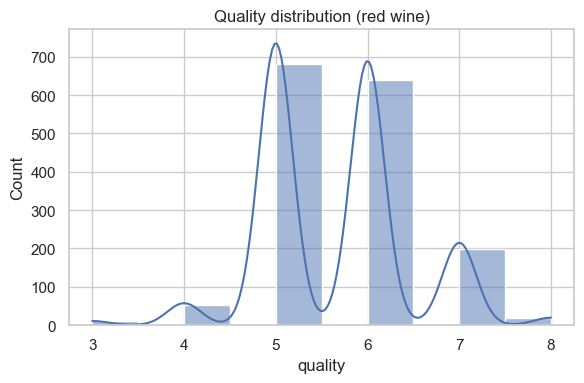

In [4]:
plt.figure(figsize=(6,4))
sns.histplot(y, bins=10, kde=True)
plt.title("Quality distribution (red wine)")
plt.tight_layout()
target_fig = FIG_DIR / "target_distribution.png"
plt.savefig(target_fig)
target_fig

PosixPath('figures/correlation_matrix.png')

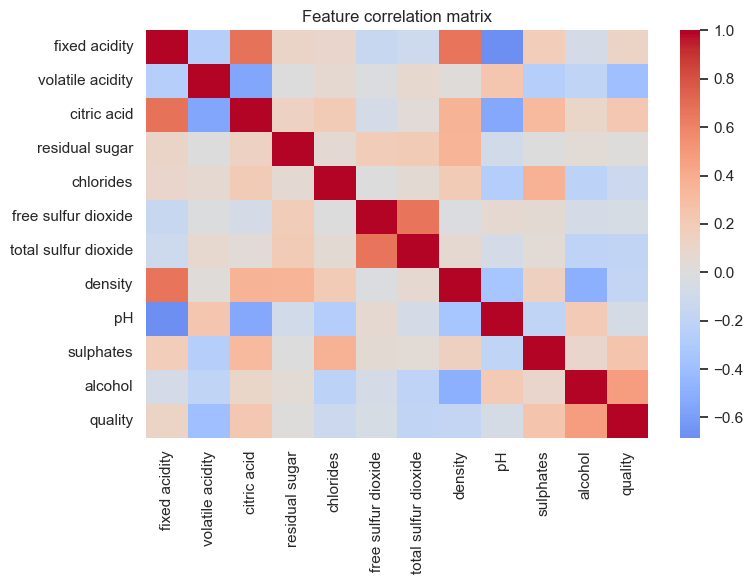

In [5]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=False, cmap="coolwarm", center=0)
plt.title("Feature correlation matrix")
plt.tight_layout()
corr_fig = FIG_DIR / "correlation_matrix.png"
plt.savefig(corr_fig)
corr_fig

## Preprocessing
- Check missingness and descriptive stats.
- All numeric features → scale.

In [6]:
missing = df.isna().sum().sum()
df.describe(), missing

(       fixed acidity  volatile acidity  citric acid  residual sugar  \
 count    1599.000000       1599.000000  1599.000000     1599.000000   
 mean        8.319637          0.527821     0.270976        2.538806   
 std         1.741096          0.179060     0.194801        1.409928   
 min         4.600000          0.120000     0.000000        0.900000   
 25%         7.100000          0.390000     0.090000        1.900000   
 50%         7.900000          0.520000     0.260000        2.200000   
 75%         9.200000          0.640000     0.420000        2.600000   
 max        15.900000          1.580000     1.000000       15.500000   
 
          chlorides  free sulfur dioxide  total sulfur dioxide      density  \
 count  1599.000000          1599.000000           1599.000000  1599.000000   
 mean      0.087467            15.874922             46.467792     0.996747   
 std       0.047065            10.460157             32.895324     0.001887   
 min       0.012000             1.

## Transformation
- Standardize features.
- PCA (variance explained) to inspect structure.

PosixPath('figures/pca_variance.png')

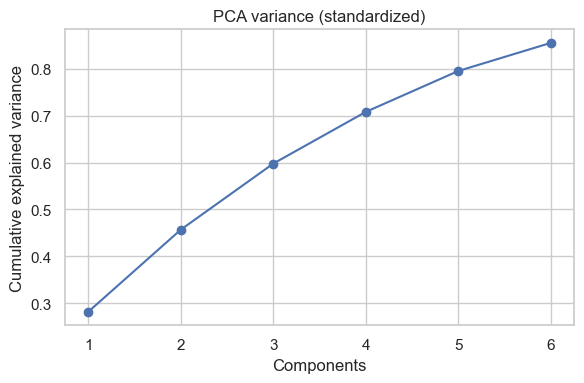

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=6, random_state=RNG)
pca.fit(X_scaled)
explained = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(6,4))
plt.plot(range(1, len(explained)+1), explained, marker='o')
plt.xlabel('Components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA variance (standardized)')
plt.tight_layout()
pca_fig = FIG_DIR / "pca_variance.png"
plt.savefig(pca_fig)
pca_fig

## Data Mining
- Pipelines: scale → model.
- Models: Dummy, RandomForest, GradientBoosting.
- Tuning: RandomizedSearchCV on GradientBoosting.

In [8]:
preprocessor = Pipeline([("scaler", StandardScaler())])

def eval_reg(model, name: str):
    pipe = Pipeline([("prep", preprocessor), ("model", model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    rmse = mean_squared_error(y_test, preds, squared=False)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    return {"name": name, "rmse": rmse, "mae": mae, "r2": r2, "pipeline": pipe}

results = []
results.append(eval_reg(DummyRegressor(strategy="median"), "Dummy"))
results.append(eval_reg(RandomForestRegressor(n_estimators=300, random_state=RNG, n_jobs=-1), "RandomForest"))
results.append(eval_reg(GradientBoostingRegressor(random_state=RNG), "GradientBoosting"))

pd.DataFrame([{k:v for k,v in r.items() if k!="pipeline"} for r in results])

,name,rmse,mae,r2
0,Dummy,0.867828,0.640625,-0.152438
1,RandomForest,0.553787,0.423667,0.530716
2,GradientBoosting,0.601943,0.484936,0.445552


In [9]:
# Pick best and tune GradientBoosting
best = sorted(results, key=lambda d: d["rmse"])[0]
best_name = best["name"]
param_dist = {
    "model__n_estimators": [200, 300, 400],
    "model__learning_rate": [0.05, 0.075, 0.1],
    "model__max_depth": [2, 3, 4],
}
search = RandomizedSearchCV(
    Pipeline([("prep", preprocessor), ("model", GradientBoostingRegressor(random_state=RNG))]),
    param_distributions=param_dist,
    n_iter=8,
    cv=3,
    scoring="neg_root_mean_squared_error",
    random_state=RNG,
    n_jobs=-1,
)
search.fit(X_train, y_train)
{'best_params': search.best_params_, 'best_cv_rmse': -search.best_score_}

{'best_params': {'model__n_estimators': 400,
  'model__max_depth': 4,
  'model__learning_rate': 0.05},
 'best_cv_rmse': 0.6343405184797611}

In [10]:
# Refit tuned model and evaluate
tuned = search.best_estimator_
tuned.fit(X_train, y_train)
preds = tuned.predict(X_test)
rmse = mean_squared_error(y_test, preds, squared=False)
mae = mean_absolute_error(y_test, preds)
r2 = r2_score(y_test, preds)
{"rmse": rmse, "mae": mae, "r2": r2}

{'rmse': 0.597696001874144,
 'mae': 0.4627656026814854,
 'r2': 0.4533476547586056}

PosixPath('figures/residuals_vs_pred.png')

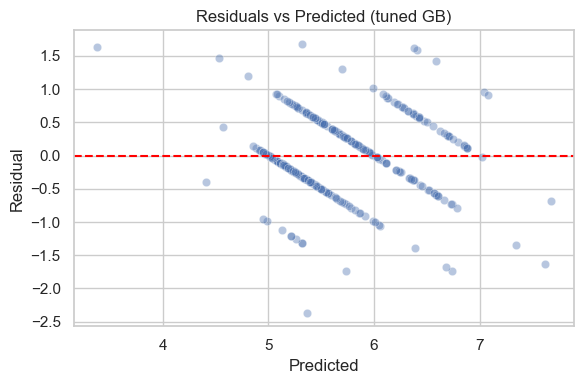

In [11]:
# Residual analysis
residuals = y_test - preds
plt.figure(figsize=(6,4))
sns.scatterplot(x=preds, y=residuals, alpha=0.4)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.title('Residuals vs Predicted (tuned GB)')
plt.tight_layout()
resid_fig = FIG_DIR / "residuals_vs_pred.png"
plt.savefig(resid_fig)
resid_fig

PosixPath('figures/residual_hist.png')

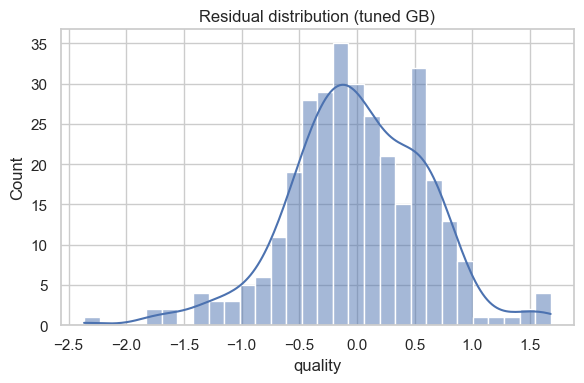

In [12]:
plt.figure(figsize=(6,4))
sns.histplot(residuals, bins=30, kde=True)
plt.title('Residual distribution (tuned GB)')
plt.tight_layout()
resid_hist_fig = FIG_DIR / "residual_hist.png"
plt.savefig(resid_hist_fig)
resid_hist_fig

PosixPath('figures/shap_beeswarm.png')

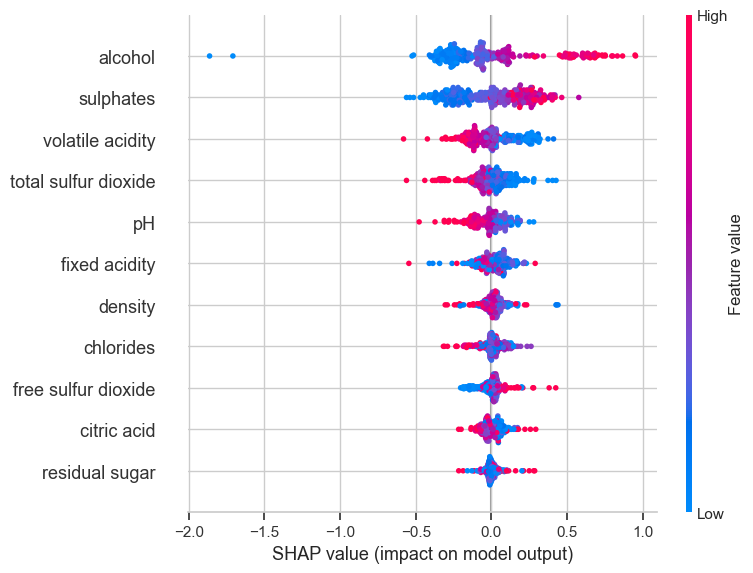

In [13]:
# SHAP summary (sampled)
X_sample = X_test.sample(n=min(400, len(X_test)), random_state=RNG)
X_proc = tuned.named_steps["prep"].transform(X_sample)
feature_names = tuned.named_steps["prep"].get_feature_names_out()
explainer = shap.Explainer(tuned.named_steps["model"], X_proc, feature_names=feature_names)
shap_values = explainer(X_proc, check_additivity=False)
shap.plots.beeswarm(shap_values, max_display=12, show=False)
plt.tight_layout()
shap_fig = FIG_DIR / "shap_beeswarm.png"
plt.savefig(shap_fig, bbox_inches="tight")
shap_fig

## Evaluation & Interpretation
- Tuned GB is best; compare RMSE/MAE/R² vs baselines.
- Residuals mostly centered, slight skew; monitor high-error cases.
- SHAP: key drivers include alcohol, sulphates, volatile acidity, density.
- PCA shows ~80% variance captured by first ~5 components.